In [6]:
import sys
sys.path.append('C:/Users/dell/Desktop/Graduate School Study/Spring 2020/Big Data in Finance/Part2/liramota-big_data2020-0c66b86dff8c/homeworks/hm_ii/liramota-fire_pytools')

In [7]:
# %% Packages

from pylab import *

from import_kf.kf_factors import *

import data_setup.stock_annual as stock_annual
import data_setup.stock_monthly as stock_monthly

from utils.monthly_date import *

from portools.find_breakpoints import find_breakpoints
from portools.sort_portfolios import sort_portfolios

desired_width = 10
pd.set_option('display.width', desired_width)
idx = pd.IndexSlice

# %% Set Up

char_breakpoints = {'me': [0.5],
                    'beme': [0.3, 0.7],
                    'opbe': [0.3, 0.7],
                    'inv': [0.3, 0.7]}

weightvar = 'melag_weights'

retvar = 'retadj'

dict_factors = {'beme': 'hml',
                'me': 'smb',
                'opbe': 'rmw',
                'inv': 'cma'}

# %% Download Data
# FF five factor
ff = kf_factors(ff_factor_file='F-F_Research_Data_5_Factors_2x3', freq='monthly')
ff.drop(columns=['date'], inplace=True)
ff_ret = ff.set_index('mdate')/100

# Annual Data

varlist = ['conm', 'fyear', 'fyr', 'at', 'capx', 'ceq', 'cogs', 'dlc', 'ib', 'icapt', 'itcb', 'lt', 'mib',
            'naicsh', 'pstk', 'pstkl', 'pstkrv',  'sale', 'seq', 'sich', 'sstk', 'txdb', 'txdi', 'txditc',
            'xint', 'xsga']
adata = stock_annual.main(varlist=varlist, complete_table=False)

# Monthly Data
mdata = stock_monthly.main()

# Set names
adata.rename(columns={'mesum_june': 'me', 'inv_gvkey': 'inv'}, inplace=True) #inv_permco
mdata.rename(columns={weightvar: 'weightvar', retvar: 'retvar'}, inplace=True)

# %% Create Filters
# Global Filters: applied to all portfolio sorts

# valid return
# ------------
print('Data deleted due to missing return: %f' % np.round(mdata.retvar.isnull().mean()*100, 2))
rdata = mdata[mdata.retvar.notnull()]

# shrcd must be (10,11)
# ---------------------
print('Data deleted due to shrcd: %f' % np.round((1-adata.shrcd.isin([10, 11]).mean())*100, 2))
sort_data = adata[adata.shrcd.isin([10, 11])].copy()

# exchcd must be (1, 2, 3)
# ------------------------
print('Data deleted due to exchcd: %f' % np.round((1-sort_data.exchcd.isin([1, 2, 3]).mean())*100, 2))
sort_data = sort_data[sort_data.exchcd.isin([1, 2, 3])]

#del adata, mdata

# Portfolio Specif Filters
sortvars = [*char_breakpoints]

# Define the break point filters
# ------------------------------
bp_filters = [None] * len(sortvars)
bp_filters = dict(zip(sortvars, bp_filters))

# Define the sample filter
# ------------------------
sample_filters = [None] * len(sortvars)
sample_filters = dict(zip(sortvars, sample_filters))

for sortvar in sortvars:
    # notice that the way we defined beme or beme is null if be<=0
    bp_filters[sortvar] = (sort_data[sortvar].notnull())
    sample_filters[sortvar] = ((sort_data.me > 0) & (sort_data.mesum_dec > 0) & (sort_data[sortvar].notnull()))

# %% Find Breakpoints
# The number of firms Ken French reports for each characteristic sort varies. This means his universe of stocks
# for sorting changes across characteristics. That is why we need to calculate breakpoints separately.
breakpoints = [None] * len(sortvars)
breakpoints = dict(zip(sortvars, bp_filters))

for sortvar in sortvars:
    breakpoints[sortvar] = find_breakpoints(data=sort_data[bp_filters[sortvar]],
                                            quantiles={sortvar: char_breakpoints[sortvar]},
                                            id_variables=['rankyear', 'permno', 'exchcd'],
                                            exch_cd=[1]
                                            )

# %% Portfolio Sorts
portsorts = [None] * len(sortvars)
portsorts = dict(zip(sortvars, bp_filters))

for sortvar in sortvars:
    portsorts[sortvar] = sort_portfolios(data=sort_data[sample_filters[sortvar]],
                                         quantiles={sortvar: char_breakpoints[sortvar]},
                                         id_variables=['rankyear', 'permno', 'exchcd'],
                                         breakpoints={sortvar: breakpoints[sortvar]}
                                         )

# merge all separate portfolio allocations together
port = portsorts['me'].copy()
for sortvar in sortvars[1:]:
    # Notice that this is an outer join
    port = port.merge(portsorts[sortvar], on=['permno', 'rankyear'], how='outer')

# %% Calculate rertuns
# Notice that this is a inner join
port_ret = pd.merge(port, rdata, on=['rankyear', 'permno'])

# TODO: calculate returns of long-short portfolios (SMB, HML, RMW, CMA)


D:\True_Anaconda\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


Stock annual calculation started.
Enter your WRDS username [dell]:jj8807
Enter your password:········
WRDS recommends setting up a .pgpass file.
You can find more info here:
https://www.postgresql.org/docs/9.5/static/libpq-pgpass.html.
Loading library list...
Done
Compustat data was successfully downloaded in 84.81485319137573 seconds.
Pension data was successfully downloaded in 5.011868715286255 seconds.
CRSP data was successfully downloaded in 216.43859338760376 seconds.
CRSP and Compsuat merge created 6 (fyear, permno) duplicates.
Keeping only the last available datadate per PERMNO.
There are 81664 PERMNOs without a valid PERMCO in DFF BE data: not present in the stock names table.
Number of not valid PERMCOs in lcomp: 0
Number of entries with valis sich:
0.0457
Number of entries with valis sich_filled:
0.003
Time to create stock_annual: 367.9229052066803 seconds
Stock monthly calculation started.
Enter your WRDS username [dell]:jj8807
Enter your password:········
WRDS recommends se

In [40]:
returns = {}
for sortvar in sortvars[1:]:
    fdata = (portsorts[sortvar].merge(portsorts['me'], how='inner').merge(rdata[['rankyear', 'date', 'permno', 'retvar','lag_me']], how="inner"))
    fdata = fdata[fdata['lag_me'].notnull()]
    returns[sortvar] = (fdata.groupby(['date', 'meportfolio', f'{sortvar}portfolio']).apply(lambda x: np.average(x['retvar'], weights = x['lag_me'])).unstack(level=[1, 2]))

In [43]:
returns

{'beme': meportfolio         me1  \
 bemeportfolio     beme1   
 date                      
 1965-01-29     0.067515   
 1965-02-26     0.033790   
 1965-03-31     0.013743   
 1965-04-30     0.017525   
 1965-05-28    -0.000504   
 ...                 ...   
 2019-08-30    -0.041228   
 2019-09-30    -0.024214   
 2019-10-31     0.043715   
 2019-11-29     0.063463   
 2019-12-31     0.033320   
 
 meportfolio              \
 bemeportfolio     beme2   
 date                      
 1965-01-29     0.053696   
 1965-02-26     0.035430   
 1965-03-31     0.007554   
 1965-04-30     0.046904   
 1965-05-28    -0.005614   
 ...                 ...   
 2019-08-30    -0.061450   
 2019-09-30     0.042230   
 2019-10-31     0.022033   
 2019-11-29     0.030811   
 2019-12-31     0.038636   
 
 meportfolio              \
 bemeportfolio     beme3   
 date                      
 1965-01-29     0.068554   
 1965-02-26     0.041056   
 1965-03-31     0.014574   
 1965-04-30     0.052219   
 1965-05

In [45]:
for sortvar, fctret in returns.items():
    returns[sortvar] = fctret['1965':'2019']

In [ ]:
#Q1

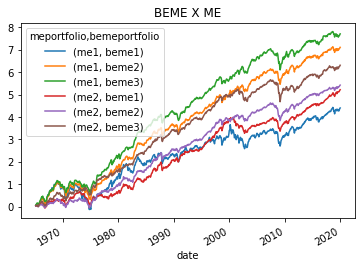

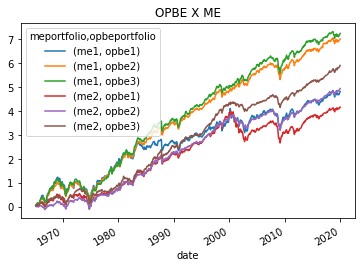

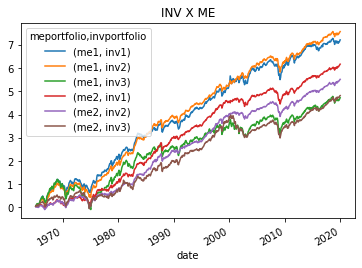

In [46]:
for sortvar in sortvars[1:]:
    np.log(1+returns[sortvar]).cumsum().plot()
    plt.title(f"{sortvar.upper()} X ME")
    plt.show()

In [ ]:
#Q2

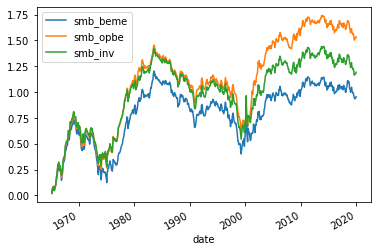

In [69]:
SMBs = {}
for sortvar in sortvars[1:]:
    SMBs[f"smb_{sortvar}"] = (returns[sortvar]['me1'].mean(axis=1) - returns[sortvar]['me2'].mean(axis=1))
SMBs = pd.DataFrame(SMBs)
np.log(1+SMBs).cumsum().plot()

In [ ]:
#Q3

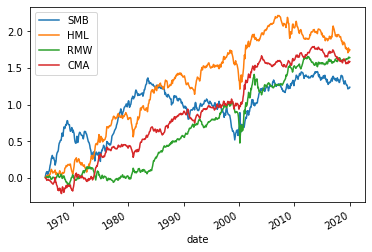

In [98]:
fcts = {}
fcts['SMB'] = SMBs.mean(axis=1)
fcts['HML'] = (returns['beme'].loc[:, idx[:, "beme3"]].mean(axis=1) - returns['beme'].loc[:, idx[:, "beme1"]].mean(axis=1))
fcts['RMW'] = (returns['opbe'].loc[:, idx[:, "opbe3"]].mean(axis=1) - returns['opbe'].loc[:, idx[:, "opbe1"]].mean(axis=1))
fcts['CMA'] = (returns['inv'].loc[:, idx[:, "inv1"]].mean(axis=1) - returns['inv'].loc[:, idx[:, "inv3"]].mean(axis=1))
fcts = pd.DataFrame(fcts)
np.log(1+fcts).cumsum().plot()

In [27]:
#Q4

In [103]:
ff_ret.describe()

,Mkt-RF,SMB,HML,RMW,CMA,RF
count,679.000000,679.000000,679.000000,679.000000,679.000000,679.000000
mean,0.005404,0.002210,0.002944,0.002567,0.002705,0.003781
std,0.043829,0.030095,0.028173,0.021554,0.019928,0.002639
min,-0.232400,-0.149100,-0.111800,-0.183300,-0.068600,0.000000
25%,-0.019500,-0.015000,-0.012700,-0.008350,-0.009850,0.001700
50%,0.009100,0.000800,0.002300,0.002300,0.001300,0.003900
75%,0.033850,0.020250,0.017000,0.012850,0.015150,0.005100
max,0.161000,0.183200,0.128700,0.133300,0.095600,0.013500


In [91]:
fcts.describe()

,SMB,HML,RMW,CMA
count,660.000000,660.000000,660.000000,660.000000
mean,0.002320,0.003049,0.002750,0.002602
std,0.030011,0.028367,0.022918,0.019884
min,-0.150850,-0.121291,-0.187118,-0.065737
25%,-0.015179,-0.013074,-0.008571,-0.010395
50%,0.000926,0.002236,0.002978,0.001215
75%,0.020801,0.017550,0.013518,0.014414
max,0.186065,0.126921,0.143107,0.093706


In [99]:
fcts.index = fcts.index.strftime('%Y%m').astype(int)

In [101]:
# sharpe ratio
fcts.subtract(ff_ret.RF, axis=0).dropna().apply(lambda x: x.mean()/x.std(), axis=0)

SMB   -0.049280
HML   -0.026926
RMW   -0.046059
CMA   -0.060730
dtype: float64

In [106]:
# correlations
fcts.corrwith(ff_ret).dropna()

SMB    0.998416
HML    0.996239
RMW    0.987953
CMA    0.982856
dtype: float64